# Autoencoder FNN for MNIST

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Autoencoder-FNN-for-MNIST" data-toc-modified-id="Autoencoder-FNN-for-MNIST-1">Autoencoder FNN for MNIST</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#class로-autoencoder-구현하기" data-toc-modified-id="class로-autoencoder-구현하기-1.0.1">class로 autoencoder 구현하기</a></span></li><li><span><a href="#encoder와-decoder를-직접-구현하여-autoencoder-만들기" data-toc-modified-id="encoder와-decoder를-직접-구현하여-autoencoder-만들기-1.0.2">encoder와 decoder를 직접 구현하여 autoencoder 만들기</a></span></li><li><span><a href="#compile,-fit" data-toc-modified-id="compile,-fit-1.0.3">compile, fit</a></span></li><li><span><a href="#시각화" data-toc-modified-id="시각화-1.0.4">시각화</a></span></li><li><span><a href="#이미지에-노이즈-추가-후-autoencoder로-제거하기" data-toc-modified-id="이미지에-노이즈-추가-후-autoencoder로-제거하기-1.0.5">이미지에 노이즈 추가 후 autoencoder로 제거하기</a></span><ul class="toc-item"><li><span><a href="#Noise-image-만들기" data-toc-modified-id="Noise-image-만들기-1.0.5.1">Noise image 만들기</a></span></li><li><span><a href="#Noise-제거-하기" data-toc-modified-id="Noise-제거-하기-1.0.5.2">Noise 제거 하기</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [1]:
from keras import datasets, layers, models, utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, _), (test_images, _) = datasets.mnist.load_data()

Using TensorFlow backend.


train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8
test_images <class 'numpy.ndarray'> (10000, 28, 28) uint8


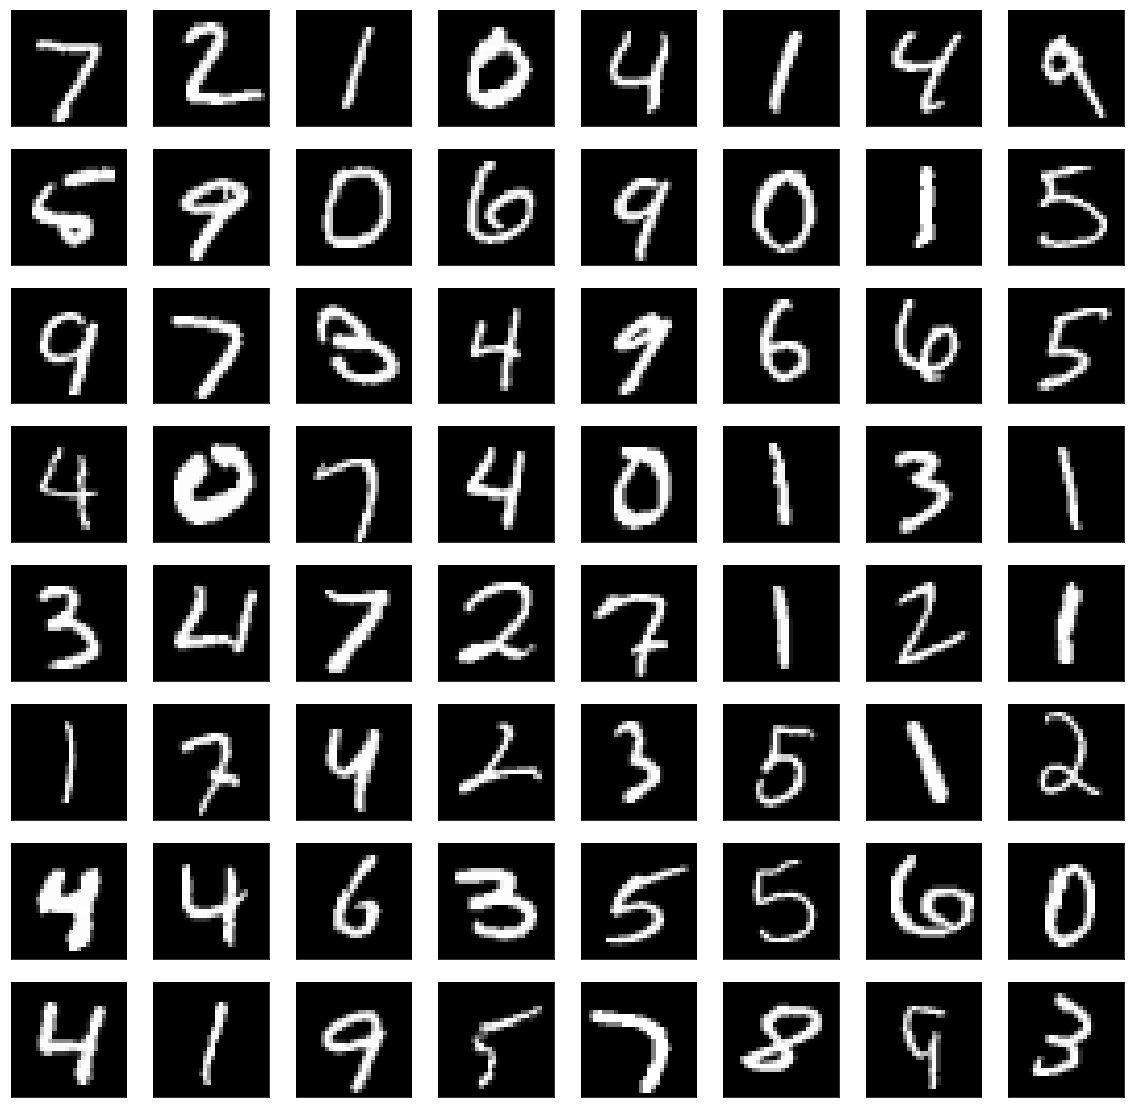

In [2]:
print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_images[i], cmap="gray" )

In [3]:
_, H, W = train_images.shape
train_x = ( train_images.reshape(-1, H, W, 1) / 255 ).astype('float32')
test_x = ( test_images.reshape(-1, H, W, 1) / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

test_x <class 'numpy.ndarray'> (10000, 28, 28, 1) float32


### class로 autoencoder 구현하기

In [4]:
# X -> Z -> y : 784 -> 36 -> 784
# Z : ReLU
# y : Sigmoid
# optimizer : adam
# loss : mse or binary_crossentropy (cf. categorical_crossentropy)

class AE(models.Model):
    
    def __init__(self, input_shape):
        x = layers.Input(shape=input_shape, name='x')
        e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e1')(x)
        e = layers.MaxPooling2D((2,2), name='e2')(e)
        e = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='e3')(e)
        e = layers.MaxPooling2D((2,2), name='e4')(e)
        e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e5')(e)
        
        z = layers.Conv2D(1, (3,3), padding='same', activation='relu', name='z')(e)
        
        d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d1')(z)
        d = layers.UpSampling2D((2,2), name='d2')(d)
        d = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='d3')(d)
        d = layers.UpSampling2D((2,2), name='d4')(d)
        d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d5')(d)
        
        y = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid', name='y')(d)
        
        super().__init__(x, y)
        
        self.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        self.x = x
        self.z = z       
        
    def encoder(self):
        return models.Model(self.x, self.z)
    
    def decoder(self):
        z = layers.Input(self.get_layer('z').output_shape[1:])
        d = self.get_layer('d1')(z)
        d = self.get_layer('d2')(d)
        d = self.get_layer('d3')(d)
        d = self.get_layer('d4')(d)
        d = self.get_layer('d5')(d)
        y = self.get_layer('z')(d)
        
        return models.Model(z, y)

In [5]:
autoencoder = AE((H, W, 1))
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
e1 (Conv2D)                  (None, 28, 28, 4)         40        
_________________________________________________________________
e2 (MaxPooling2D)            (None, 14, 14, 4)         0         
_________________________________________________________________
e3 (Conv2D)                  (None, 14, 14, 8)         296       
_________________________________________________________________
e4 (MaxPooling2D)            (None, 7, 7, 8)           0         
_________________________________________________________________
e5 (Conv2D)                  (None, 7, 7, 4)           292       
_________________________________________________________________
z (C

In [8]:
encoder = autoencoder.encoder()
decoder = autoencoder.decoder()
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
e1 (Conv2D)                  (None, 28, 28, 4)         40        
_________________________________________________________________
e2 (MaxPooling2D)            (None, 14, 14, 4)         0         
_________________________________________________________________
e3 (Conv2D)                  (None, 14, 14, 8)         296       
_________________________________________________________________
e4 (MaxPooling2D)            (None, 7, 7, 8)           0         
_________________________________________________________________
e5 (Conv2D)                  (None, 7, 7, 4)           292       
_________________________________________________________________
z (Conv2D)                   multiple                  37        
Total para

### encoder와 decoder를 직접 구현하여 autoencoder 만들기

In [5]:
x = layers.Input(shape=(H, W, 1), name='x')
e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e1')(x)
e = layers.MaxPooling2D((2,2), name='e2')(e)
e = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='e3')(e)
e = layers.MaxPooling2D((2,2), name='e4')(e)
e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e5')(e)

z = layers.Conv2D(1, (3,3), padding='same', activation='relu', name='z')(e)

encoder = models.Model(x, z)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
z = layers.Input(shape=encoder.get_layer('z').output_shape[1:], name='z')

d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d1')(z)
d = layers.UpSampling2D((2,2), name='d2')(d)
d = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='d3')(d)
d = layers.UpSampling2D((2,2), name='d4')(d)
d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d5')(d)

y = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid', name='y')(d)

decoder = models.Model(z, y)

In [9]:
autoencoder = models.Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

encoder.summary()
decoder.summary()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
e1 (Conv2D)                  (None, 28, 28, 4)         40        
_________________________________________________________________
e2 (MaxPooling2D)            (None, 14, 14, 4)         0         
_________________________________________________________________
e3 (Conv2D)                  (None, 14, 14, 8)         296       
_________________________________________________________________
e4 (MaxPooling2D)            (None, 7, 7, 8)           0         
_________________________________________________________________
e5 (Conv2D)                  (None, 7, 7, 4)           292       
_________________________________________________________________
z (Conv2D)                   (None, 7, 7, 1)           37        
Total para

### compile, fit

In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
hist = autoencoder.fit(train_x, train_x, batch_size=128, epochs=20, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 40s 825us/step - loss: 0.2838 - acc: 0.7895 - val_loss: 0.1242 - val_acc: 0.8083
Epoch 2/20
48000/48000 [==============================] - 42s 874us/step - loss: 0.1134 - acc: 0.8096 - val_loss: 0.1083 - val_acc: 0.8106
Epoch 3/20
48000/48000 [==============================] - 37s 776us/step - loss: 0.1034 - acc: 0.8113 - val_loss: 0.1018 - val_acc: 0.8122
Epoch 4/20
48000/48000 [==============================] - 38s 799us/step - loss: 0.0991 - acc: 0.8119 - val_loss: 0.0985 - val_acc: 0.8130
Epoch 5/20
48000/48000 [==============================] - 35s 739us/step - loss: 0.0965 - acc: 0.8123 - val_loss: 0.0966 - val_acc: 0.8128
Epoch 6/20
48000/48000 [==============================] - 34s 714us/step - loss: 0.0947 - acc: 0.8126 - val_loss: 0.0948 - val_acc: 0.8134
Epoch 7/20
48000/48000 [==============================] - 39s 806us/

### 시각화

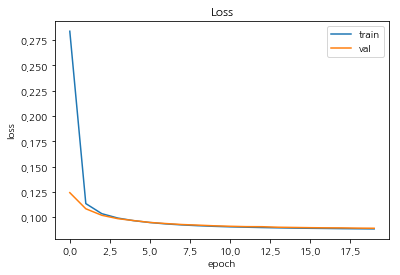

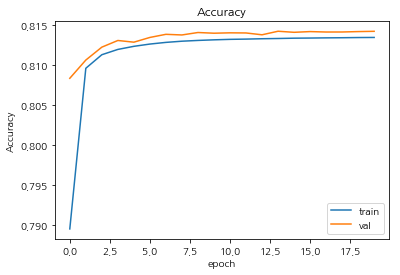

10000/10000 [==============================] - 2s 163us/step
[loss, accuracy]: [0.08743490202426911, 0.8126084201812744]


In [12]:
from modules.plot_history import plot_loss, plot_acc

plot_loss(hist, 'Loss')
plt.show()
plot_acc(hist, 'Accuracy')
plt.show()

performance_test = autoencoder.evaluate(test_x, test_x, batch_size=128)
print('[loss, accuracy]:', performance_test)

In [13]:
# decoded_imgs = autoencoder.predict(test_x)
encoded_imgs = encoder.predict(test_x)
decoded_imgs = decoder.predict(encoded_imgs)

print( 'encoded_imgs.shape =', encoded_imgs.shape )
print( 'decoded_imgs.shape =', decoded_imgs.shape )

encoded_imgs.shape = (10000, 7, 7, 1)
decoded_imgs.shape = (10000, 28, 28, 1)


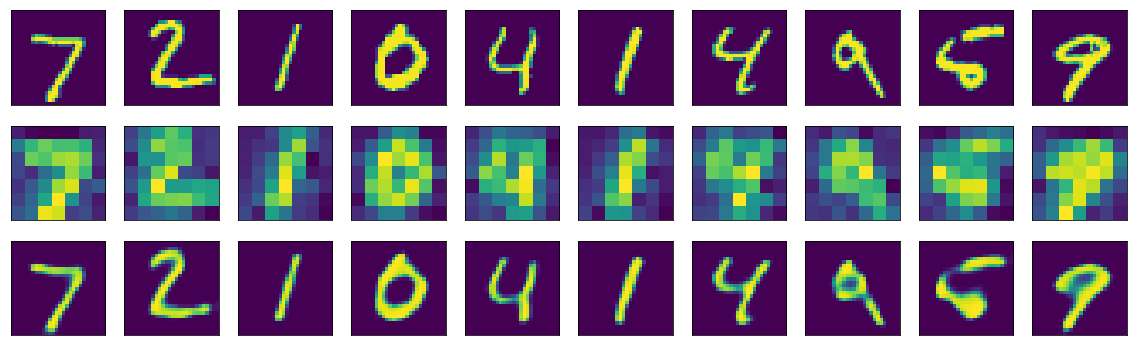

In [14]:
plt.figure( figsize=(20,6) )
n = 10

for i in range(0, n):
    plt.subplot(3, 10, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_x[i].reshape(H,W) )

    plt.subplot(3, 10, 10+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( encoded_imgs[i].reshape(7,7) )

    plt.subplot(3, 10, 20+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( decoded_imgs[i].reshape(H,W) )

plt.show()

### 이미지에 노이즈 추가 후 autoencoder로 제거하기

#### Noise image 만들기

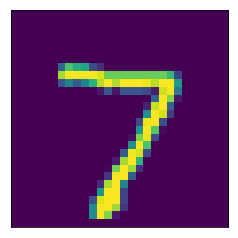

In [16]:
plt.xticks([]); plt.yticks([])
plt.imshow( test_x[0].reshape(H,W) )
plt.show()

In [36]:
noise_img = np.zeros_like(test_x[0])

num_noise_point = 8
noise_posx = np.random.randint(0, H, num_noise_point)
noise_posy = np.random.randint(0, W, num_noise_point)

for i in range(num_noise_point):
    noise_img[noise_posx[i], noise_posy[i], 0] = 1

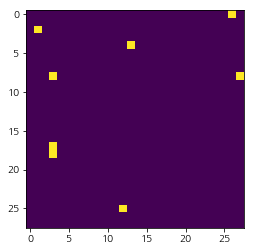

In [37]:
plt.imshow(noise_img.reshape(H,W))

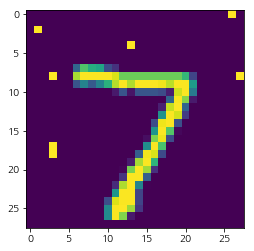

In [41]:
test_x_noise = test_x[0] + noise_img
test_x_noise = np.clip(test_x_noise, 0, 1)
plt.imshow(test_x_noise.reshape(H,W))

In [42]:
test_x_noise = np.clip(test_x + noise_img, 0, 1)

#### Noise 제거 하기

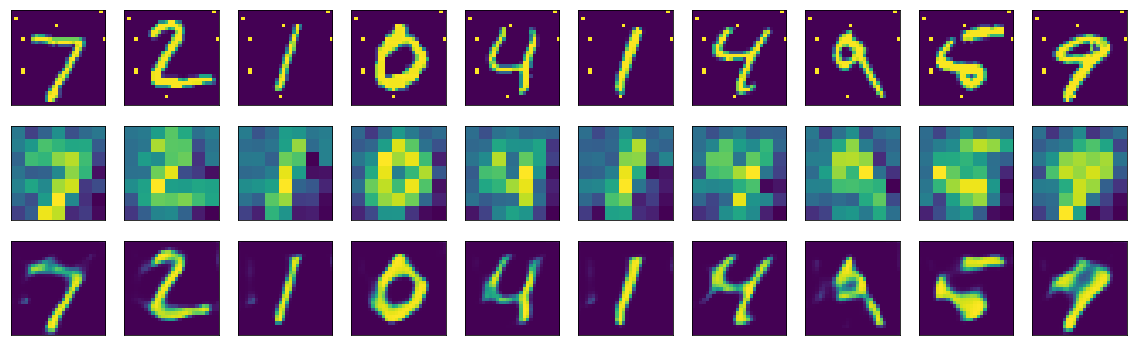

In [43]:
encoded_imgs = encoder.predict(test_x_noise)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure( figsize=(20,6) )
n = 10

for i in range(0, n):
    plt.subplot(3, 10, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_x_noise[i].reshape(H,W) )

    plt.subplot(3, 10, 10+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( encoded_imgs[i].reshape(7,7) )

    plt.subplot(3, 10, 20+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( decoded_imgs[i].reshape(H,W) )

plt.show()